# 2D Advection-Diffusion equation

in this notebook we provide a simple example of the DeepMoD algorithm and apply it on the 2D advection-diffusion equation. 

In [8]:
import numpy as np
import pandas as pd 

from scipy.io import loadmat
from deepymod.DeepMoD import DeepMoD
from deepymod.library_functions import library_2Din_1Dout
from deepymod.utilities import library_matrix_mat, print_PDE

import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

np.random.seed(42)  # setting seed for randomisation

Set the noise level, number of samples, architecture and strength of the $L_1$ penalty.
Note that we have three input channels in this example: {x,y,t}

In [11]:
noise_level = 0.1
number_of_samples = 1000
layers = [3, 20, 20, 20, 20, 20, 1]
l1 = 10**-6

In [12]:
# %%Importing and preparing data

data = loadmat('data/Advection_diffusion.mat')
usol = np.real(data['Expression1'])
usol= usol.reshape((51,51,61,4))

x_v= usol[:,:,:,0]
y_v = usol[:,:,:,1]
t_v = usol[:,:,:,2]
u_v = usol[:,:,:,3]

X = np.transpose((t_v.flatten(),x_v.flatten(), y_v.flatten()))
y = u_v.reshape((u_v.size, 1))
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)

idx = np.random.permutation(y.size)
X_train = X[idx, :][:number_of_samples]
y_train = y[idx, :][:number_of_samples]

In [13]:
config = {'layers': layers, 'lambda': l1}
library_config = {'total_terms': 12, 'deriv_order': 2, 'poly_order': 1}
train_opts = {'max_iterations': 50000, 'grad_tol':10**-7, 'learning_rate': 0.002, 'beta1': 0.99, 'beta2': 0.999, 'epsilon': 10**-8}
output_opts = {'output_directory': 'output/AD/', 'X_predict': X}

Running DeepMoD

Configure DeepMoD: Note we have a 2D+1 input so the 2Din_1Dout library has te be selected 

In [14]:
sparse_vectors, denoised = DeepMoD(X_train, y_train, config, library_2Din_1Dout, library_config, train_opts, output_opts)

Epoch | Total loss | Loss gradient | MSE | PI | L1 
0 [0.30983734, 0.011058755, 0.25312775, 0.056700896, 8.701146e-06]
500 [0.017407766, 0.00908428, 0.012386838, 0.005017042, 3.886367e-06]
1000 [0.0014680729, 0.0006059256, 0.000923538, 0.0005421901, 2.3448092e-06]
1500 [0.0004367726, 0.00024096196, 0.00025027175, 0.00018456085, 1.9400127e-06]
2000 [0.00021153172, 0.0001605865, 0.00011707905, 9.261835e-05, 1.8343057e-06]
2500 [0.00011838312, 9.894276e-05, 5.914698e-05, 5.7424306e-05, 1.8118305e-06]
3000 [7.42896e-05, 4.8020353e-05, 3.3196222e-05, 3.9301278e-05, 1.7921058e-06]
3500 [5.0630853e-05, 3.155696e-05, 2.0393842e-05, 2.8434579e-05, 1.8024313e-06]
4000 [3.5893376e-05, 1.8521478e-05, 1.3266613e-05, 2.081618e-05, 1.8105825e-06]
4500 [2.5747135e-05, 9.543028e-06, 8.840548e-06, 1.5094853e-05, 1.8117328e-06]
5000 [1.871908e-05, 4.6087225e-06, 6.009928e-06, 1.0899613e-05, 1.8095405e-06]
5500 [1.4336093e-05, 7.3029955e-06, 4.451963e-06, 8.077699e-06, 1.8064312e-06]
6000 [1.1686357e-05, 

Show final result:

In [15]:
u = ['1', 'u']
du = ['1', 'u_{x}', 'u_{y}','u_{xx}', 'u_{yy}','u_{xy}']
coeffs_list = library_matrix_mat(u, du)

print('Inferred equation:')
print_PDE(sparse_vectors[0], coeffs_list, PDE_term='u_t')

Inferred equation:
u_t = 0.249u_{x} + 0.500u_{y} + 0.495u_{xx} + 0.502u_{yy}


Plot the 'Ground truth', 'Noisy' and 'Reconstructed/Denoised' solution

In [35]:
X_predict = X[(X[:,0]==5.0) | (X[:,0]==9.0) | (X[:,0]==7.0), :]

In [33]:
data_dict = {'x_grid': X[:,1],'y_grid': X[:,2], 't_grid': X[:,0], 'ground_truth': np.squeeze(y), 'noisy': np.squeeze(y_noisy)}
df = pd.DataFrame(data_dict)
for key in df:
    df[key] = np.squeeze(df[key])
data = pd.DataFrame(df)

In [40]:
data_dict_denoised = {'x_grid': X[:,1],'y_grid': X[:,2], 't_grid': X[:,0], 'denoised': np.squeeze(denoised)}
df_dn = pd.DataFrame(data_dict_denoised)
for key in df_dn:
    df_dn[key] = np.squeeze(df_dn[key])
data_denoised = pd.DataFrame(df_dn)

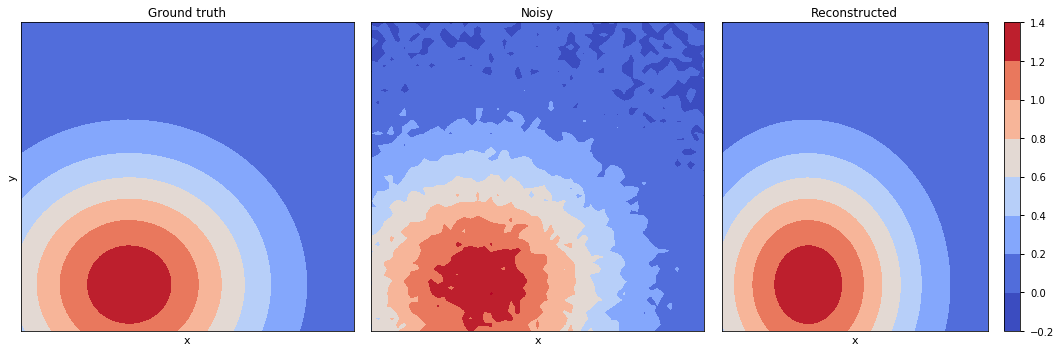

In [47]:
time1 = 7.0

vmin = np.min(data[data['t_grid'] == time1]['ground_truth'])
vmax = np.max(data[data['t_grid'] == time1]['ground_truth'])

#%%
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, nrows=1, figsize= (15, 5))
im1 = ax1.contourf(pd.pivot_table(data[data['t_grid'] == time1],index='y_grid', columns='x_grid', values='ground_truth'), cmap='coolwarm',vmin=vmin, vmax=vmax)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Ground truth')

im2 = ax2.contourf(pd.pivot_table(data[data['t_grid'] == time1],index='y_grid', columns='x_grid', values='noisy'), cmap='coolwarm', vmin=vmin, vmax=vmax)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('x')
ax2.set_title('Noisy')

im3 = ax3.contourf(pd.pivot_table(data_denoised[data_denoised['t_grid'] == time1],index='y_grid', columns='x_grid', values='denoised'), cmap='coolwarm', vmin=vmin, vmax=vmax)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel('x')
ax3.set_title('Reconstructed')
plt.colorbar(im3)

plt.tight_layout()
